In [ ]:
import numpy as np
import pandas as pd 
import random
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics.cluster import adjusted_rand_score
from matplotlib.textpath import TextPath
from sklearn.cluster import SpectralClustering
import math
%matplotlib inline
print('done')

done


In [ ]:
# creating MDS models
model = MDS(n_components=2,dissimilarity='precomputed',random_state=42)
model1 = MDS(n_components=2,random_state=42) #euclidian distance 

## Table of content

* [Functions](#func)
* [DGPs](#DGPs) 
* [RF Proximities](#prox)
* [Clustering](#clustering)
* [MDS example](#MDS)

## Functions <a name="func"></a> 

In [ ]:

def kMedoids(D, k, tmax=100):
    # determine dimensions of distance matrix D
    m, n = D.shape

    if k > n:
        raise Exception('too many medoids')

    # find a set of valid initial cluster medoid indices since we
    # can't seed different clusters with two points at the same location
    valid_medoid_inds = set(range(n))
    invalid_medoid_inds = set([])
    rs,cs = np.where(D==0)
    # the rows, cols must be shuffled because we will keep the first duplicate below
    index_shuf = list(range(len(rs)))
    np.random.shuffle(index_shuf)
    rs = rs[index_shuf]
    cs = cs[index_shuf]
    for r,c in zip(rs,cs):
        # if there are two points with a distance of 0...
        # keep the first one for cluster init
        if r < c and r not in invalid_medoid_inds:
            invalid_medoid_inds.add(c)
    valid_medoid_inds = list(valid_medoid_inds - invalid_medoid_inds)

    if k > len(valid_medoid_inds):
        raise Exception('too many medoids (after removing {} duplicate points)'.format(
            len(invalid_medoid_inds)))

    # randomly initialize an array of k medoid indices
    M = np.array(valid_medoid_inds)
    np.random.shuffle(M)
    M = np.sort(M[:k])

    # create a copy of the array of medoid indices
    Mnew = np.copy(M)

    # initialize a dictionary to represent clusters
    C = {}
    for t in range(tmax):
        # determine clusters, i. e. arrays of data indices
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]
        # update cluster medoids
        for kappa in range(k):
            J = np.mean(D[np.ix_(C[kappa],C[kappa])],axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)
        # check for convergence
        if np.array_equal(M, Mnew):
            break
        M = np.copy(Mnew)
    else:
        # final update of cluster memberships
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

    # return results
    return M, C

In [ ]:
def transform_dataset(dataset):
    data = list()
    for i in range(len(dataset)):
        row = dataset.iloc[i,:].tolist()
        data.append(row)
    return data
    
    

In [ ]:
def add_synthetic(dataset):
  
  
  frame = dict()

  for i in range(len(dataset.columns)):
    a = resample(dataset.iloc[:,i]).reset_index(drop=True)
    frame[dataset.columns[i]] = a

  frame['index'] = range(len(dataset),len(dataset)*2)
        
  synthetic_dataset = pd.DataFrame(frame)
  synthetic_dataset = synthetic_dataset.set_index('index')
    
  synthetic_dataset['label'] = 1
  
  dataset['label'] = 0
  complete_dataset = pd.concat([dataset,synthetic_dataset])
  dataset.drop('label',axis=1,inplace=True)
  return complete_dataset

In [ ]:

# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right

# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini



    
# Select the best split point for a dataset
def get_split(dataset, n_features,weights):
    class_values = list(set(row[-1] for row in dataset))
    classes = [row[-1] for row in dataset]
    if len(set(classes)) <2:
        leaf = to_terminal(dataset)
        return leaf
    else: 
        b_index, b_value, b_score, b_groups = 999, 999, 999, None
        df = pd.DataFrame(data = dataset)
        df.drop(df.columns[-1],axis=1,inplace=True)
        features = df.sample(n=n_features,weights=weights,axis=1).columns  # Weights = None: results in equal probability weighting
        for index in features:
            for row in dataset:
                groups = test_split(index, row[index], dataset)
                gini = gini_index(groups, class_values)
                if gini < b_score:
                    b_index, b_value, b_score, b_groups = index,row[index],gini,groups                
        return {'index':b_index, 'value':b_value, 'gini':b_score, 'groups':b_groups} 

In [ ]:
# Create a terminal node value   #returns either 0 or 1 

def to_terminal(group):
    global leaf
    leaf+=1
    outcomes = [row[-1] for row in group]    
    return (max(set(outcomes), key=outcomes.count),leaf)
    

# Create child splits for a node or make terminal
def split(node, max_depth, min_size, n_features, depth, weights):
    left, right = node['groups']
    del(node['groups'])   
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)  
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left, n_features,weights) 
        if isinstance(node['left'],tuple):
            node['left'] = node['left']
        else:
            split(node['left'], max_depth, min_size, n_features, depth+1,weights)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right, n_features,weights) 
        if isinstance(node['right'],tuple):
            node['right'] = node['right']
        else:
            split(node['right'], max_depth, min_size, n_features, depth+1,weights)

In [ ]:
# builds the tree 

def build_tree(train, max_depth, min_size, n_features,weights):
	root = get_split(train, n_features,weights)  
	split(root, max_depth, min_size, n_features, 1,weights)  
	return root

In [ ]:
# Print a decision tree
def print_tree(node, depth=0):
	if isinstance(node, dict):
		print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
		print_tree(node['left'], depth+1)
		print_tree(node['right'], depth+1)
	else:
		print('%s%s' % ((depth*' ', node)))

In [ ]:
# Make a prediction with a decision tree
def predict(node, row):   
	if row[node['index']] < node['value']: 
                                             
		if isinstance(node['left'], dict):  
			return predict(node['left'], row)  
		else:                                   
			return node['left']
	else:                                        
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']

In [ ]:
def apply(tree,X):
    indexes = list()
    for row in X:
        indexes.append(predict(tree,row)[1])
    return indexes
    


In [ ]:
def subsample(dataset, ratio):
    sample = list()   
    n_sample = round(len(dataset) * ratio)
    sample_indexes = list()
    while len(sample) < n_sample:
        index = random.randrange(len(dataset))
        sample_indexes.append(index)
        sample.append(dataset[index])
    s_ind = list(dict.fromkeys(sample_indexes))
    oob_indexes = list()
    for index in range(len(dataset)):
        if index not in s_ind:
            oob_indexes.append(index)
    return [sample,oob_indexes]

In [ ]:
def sum_gini(node):  
  global gini_sum
  gini_sum[node['index']] += node['gini']
  if isinstance(node['left'], dict):
    sum_gini(node['left'])
  if isinstance(node['right'], dict):
    sum_gini(node['right'])

In [ ]:
def get_indexes(train,X_apply,n_trees,max_depth,min_size,n_features,weights,oob = True):
    trees = list()
    oob_indexes = list()
    for i in range(n_trees):
        sample = subsample(train,1)
        oob_indexes.append(sample[1]) 
        global leaf
        leaf = 0
        tree = build_tree(sample[0],max_depth, min_size,n_features,weights)
        trees.append(tree)
    leaf_indexes = list()
    for tree in trees:
        leaf_indexes.append(apply(tree,X_apply))
    leaf_indexes = np.asarray(leaf_indexes)
    global gini_sum 
    gini_sum = list()
    for i in range(len(train[0])-1):
        gini_sum.append(0)
    for tree in trees:
        sum_gini(tree)
    gini_sum [:] = [x / n_trees for x in gini_sum]    
    if oob:
        #compute the oobscore 
        return [leaf_indexes,trees,oob_indexes,gini_sum]
    else:
        return [leaf_indexes,gini_sum]

In [ ]:
def oob_score(trees,oob_indexes,dataset):
    oob_predictions = list()
    for i in range(len(trees)):
        for index in oob_indexes[i]:
            oob_predictions.append((index,predict(trees[i],dataset[index])[0]))
    
    row_indexes = list()
    for i in range(len(oob_predictions)):
        row_indexes.append(oob_predictions[i][0])
    unique_row_indexes = set(row_indexes)

    # create a list with all the predictions for every row 
    main = list()
    for index in unique_row_indexes:
        l = list()
        l.append([index])
        r = list()
        for i in range(len(oob_predictions)):
            if index == oob_predictions[i][0]:
                r.append(oob_predictions[i][1])
        l.append(r)
        main.append(l)
    
    outcomes = [row[-1] for row in dataset]
    accuracy = list()
    for i in range(len(main)):
        if max(set(main[i][1]), key=main[i][1].count) == outcomes[main[i][0][0]]:
            accuracy.append(True)
        else:
            accuracy.append(False)
        
    c = Counter(accuracy)
    oob_score = dict(c)[True] / sum(c.values())
            
    return oob_score

In [ ]:
def proxmat(terminals):
    nTrees = terminals.shape[0]

    a = terminals[0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees
    
    return proxMat 

In [ ]:
def get_proximity_matrix(train,X_apply,n_trees,max_depth,min_size,n_features,weights,oob):
    
    """ Weights = ‘None’ results in equal probability weighting. If passed a Series, will align with target object on index. 
        Index values in weights not found in sampled object will be ignored and index values in sampled object not in weights
        will be assigned weights of zero. Unless weights are a Series, weights must be same length as axis being sampled. 
        If weights do not sum to 1, they will be normalized to sum to 1. 
        Missing values in the weights column will be treated as zero. Infinite values not allowed.
        
        oob: True or False
        """
    terminals = get_indexes(train,X_apply,n_trees,max_depth,min_size,n_features,weights,oob)
    proximity_mat = proxmat(terminals[0])
    if oob == True:
        oob_sc = oob_score(terminals[1],terminals[2],train)
        return [proximity_mat,oob_sc,terminals[3]]
    else:
        return [proximity_mat,terminals[1]] 

In [ ]:
def colorize(dataframe):
    dataframe['colors'] = 0
    for i in range(len(dataframe)):
        if dataframe.iloc[i,-2] == 1:
            dataframe.iloc[i,-1] = '#000000' #black
        if dataframe.iloc[i,-2] == 2:
            dataframe.iloc[i,-1] = '#e04242' #red
        if dataframe.iloc[i,-2] == 3:
            dataframe.iloc[i,-1] = '#42e05d' #green
        if dataframe.iloc[i,-2] == 4:
            dataframe.iloc[i,-1] = '#35aede' #blue 
    colors = dataframe['colors']
    dataframe.drop('colors',axis=1,inplace=True)
    dataframe.drop('cluster',axis=1,inplace=True)
    return colors
        

## DGPs <a name="DGPs"></a> 

### Ex1

In [ ]:
# data sim  Ex1

# Creating clusters with 150 samples and 9 variables

columns = ['X1','X2','X3','X4','X5','X6','X7','X8','X9']

# Cluster 1.


cluster_1 = pd.DataFrame(np.concatenate((np.random.uniform(-1,0,size=(150,1)), np.random.uniform(0,1,size=(150,1)),
                                         np.random.uniform(0,1,size=(150,1)), np.random.normal(0,1,(150,1)), 
                                         np.random.normal(0,1,(150,1)), np.random.normal(0,1,(150,1)),
                                         np.random.normal(0,1,(150,1)), np.random.normal(0,1,(150,1)), 
                                         np.random.normal(0,1,(150,1))),axis=1),
                                         columns=columns) 
cluster_1['cluster'] = 1

# Cluster 2. 


cluster_2 = pd.DataFrame(np.concatenate((np.random.uniform(0,1,size=(150,1)), np.random.uniform(0,1,size=(150,1)),
                                         np.random.uniform(0,1,size=(150,1)), np.random.normal(0,1,(150,1)), 
                                         np.random.normal(0,1,(150,1)), np.random.normal(0,1,(150,1)),
                                         np.random.normal(0,1,(150,1)), np.random.normal(0,1,(150,1)), 
                                         np.random.normal(0,1,(150,1))),axis=1),
                                         columns=columns) 
cluster_2['cluster'] = 2



Ex1 = pd.concat([cluster_1,cluster_2],ignore_index=True) # 300 rows, 10 features, cluster col.

Ex1_clust = Ex1['cluster']

#Ex1.drop('cluster',axis=1,inplace=True)

In [ ]:
colors = colorize(Ex1)

In [ ]:
# correlation map

plt.matshow(Ex1.corr())
plt.xticks(range(len(Ex1.columns)), Ex1.columns)
plt.yticks(range(len(Ex1.columns)), Ex1.columns)
plt.colorbar()
plt.show()

### Ex2

In [ ]:

# Creating clusters with 100 samples and 9 variables

columns = ['X1','X2','X3','X4','X5','X6','X7','X8','X9']
X_1st = np.random.uniform(0.8,1,size=(100,1))
X_1st_1 = np.random.uniform(0.8,1,size=(100,1))
X_2nd = np.random.uniform(0,0.8,size=(100,1))
X_2nd_1 = np.random.uniform(0,0.8,size=(100,1))




cluster_1 = pd.DataFrame(np.concatenate((X_1st, np.random.uniform(0.8,1,size=(100,1)),
                                         np.random.choice([0], size=(100,1)),
                                         np.random.uniform(1,2,size=(100,1)),
                                         np.random.normal(0,1,(100,1)),
                                         np.random.normal(0,1,(100,1)),
                                         np.random.permutation(X_1st), np.random.permutation(X_1st),
                                         np.random.permutation(X_1st)),
                                         axis=1),
                                         columns=columns) 
cluster_1['cluster'] = 1

cluster_2 = pd.DataFrame(np.concatenate((X_1st_1, np.random.uniform(0.8,1,size=(100,1)),
                                         np.random.choice([1], size=(100,1)),
                                         np.random.uniform(2,3,size=(100,1)),
                                         np.random.normal(0,1,(100,1)),
                                         np.random.normal(0,1,(100,1)), np.random.permutation(X_1st_1),
                                         np.random.permutation(X_1st_1),np.random.permutation(X_1st_1)),
                                         axis=1),
                                         columns=columns) 
cluster_2['cluster'] = 2




cluster_3 = pd.DataFrame(np.concatenate((X_2nd, np.random.uniform(0,0.8,size=(100,1)),
                                         np.random.choice([0], size=(100,1)),
                                         np.random.uniform(1,2,size=(100,1)),
                                         np.random.normal(0,1,(100,1)), np.random.normal(0,1,(100,1)),
                                         np.random.permutation(X_2nd),
                                         np.random.permutation(X_2nd),np.random.permutation(X_2nd)),
                                         axis=1),
                                         columns=columns)  
cluster_3['cluster'] = 3

cluster_4 = pd.DataFrame(np.concatenate((X_2nd_1, np.random.uniform(0,0.8,size=(100,1)),
                                         np.random.choice([1], size=(100,1)),
                                         np.random.uniform(2,3,size=(100,1)),
                                         np.random.normal(0,1,(100,1)), np.random.normal(0,1,(100,1)),
                                         np.random.permutation(X_2nd_1),np.random.permutation(X_2nd_1),
                                         np.random.permutation(X_2nd_1)),
                                         axis=1),
                                         columns=columns)  
cluster_4['cluster'] = 4



Ex2 = pd.concat([cluster_1,cluster_2,cluster_3,cluster_4],ignore_index=True) 
Ex2_clust = Ex2['cluster']

#Ex2.drop('cluster',axis=1,inplace=True)

In [ ]:
colors = colorize(Ex2)

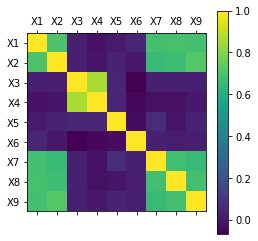

In [ ]:
# correlation map

plt.matshow(Ex2.corr())
plt.xticks(range(len(Ex2.columns)), Ex2.columns)
plt.yticks(range(len(Ex2.columns)), Ex2.columns)
plt.colorbar()
plt.show()

### Ex3

In [ ]:


columns = ['X1','X2','X3','X4','X5']



cluster_1 = pd.DataFrame(np.concatenate(( np.random.normal( -5,1,(100,1)),  np.random.normal(-5,1,(100,1)),
                                         #np.random.choice([0], size=(100,1)),
                                         np.random.uniform(-1,0,size=(100,1)),
                                          np.random.normal(-5,1,(100,1)),  np.random.normal(-5,1,(100,1)), 
                                         ),axis=1),
                                         columns=columns) 
cluster_1['cluster'] = 1


cluster_2 = pd.DataFrame(np.concatenate(( np.random.normal(-5,1,(100,1)),  np.random.normal(-5,1,(100,1)),
                                         #np.random.choice([1], size=(100,1)),
                                         np.random.uniform(0,1,size=(100,1)),
                                         np.random.normal(-5,1,(100,1)),  np.random.normal(-5,1,(100,1)),
                                         ),axis=1),
                                         columns=columns)  

cluster_2['cluster'] = 2

Ex3 = pd.concat([cluster_1,cluster_2],ignore_index=True) 

Ex3_clust = Ex3['cluster']

#Ex3.drop('cluster',axis=1,inplace=True)

In [ ]:
colors = colorize(Ex3)

In [ ]:
# correlation map

plt.matshow(Ex3.corr())
plt.xticks(range(len(Ex3.columns)), Ex3.columns)
plt.yticks(range(len(Ex3.columns)), Ex3.columns)
plt.colorbar()
plt.show()

## Random Forest Proximities <a name="prox"></a> 

In [ ]:
data= add_synthetic(Ex2)
train = transform_dataset(data)
X_apply = transform_dataset(Ex2)

In [ ]:
matrix = get_proximity_matrix(train,X_apply,100,3000,2,3, 
                              #weights = [0.1,0.1,0.6,0.1,0.1]
                              #weights = [0.05,0.05,0.325,0.325,0.05,0.05,0.05,0.05,0.05]                      
                              #weights = [(44/60)/14,1/60,(44/60)/14,(44/60)/14,1/60,(44/60)/14,(44/60)/14,(44/60)/14,1/60,1/60,1/60,1/60,1/60,(44/60)/14,1/60,1/60,(44/60)/14,1/60,1/60,1/60,(44/60)/14,1/60,(44/60)/14,(44/60)/14,1/60,(44/60)/14,(44/60)/14,(44/60)/14,1/60,1/60]
                              weights = None
                              #weights = [0,0.15,0.15,0,0,0.15,0,0.15,0.15,0,0.15,0.15,0.15]
                              ,oob = False)

In [ ]:
diss1 = 1 - matrix[0]

In [ ]:
matrix[1] #oob

0.945

Text(0.5, 1.0, 'Uniform RF dissimilarity')

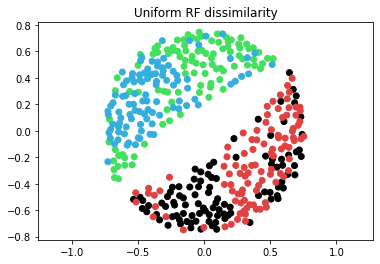

In [ ]:
out = model.fit_transform(diss1)
plt.scatter(out[:, 0], out[:, 1], c = colors,alpha=1)
plt.axis('equal');
plt.title('Uniform RF dissimilarity')

### Var imp measure chart 

Text(0.5, 1.0, 'VIMs plotted for Uniform RF')

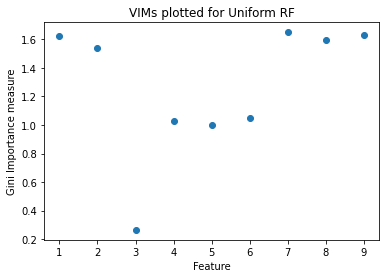

In [ ]:
plt.scatter(range(1,len(matrix[1])+1),matrix[1])
plt.xticks(range(1,len(matrix[1])+1))
plt.xlabel('Feature')
plt.ylabel('Gini Importance measure')
plt.title('VIMs plotted for Uniform RF')

In [ ]:
# if OOB = False 

plt.scatter(range(1,len(matrix[1])+1),matrix[1])
plt.xticks(range(1,len(matrix[1])+1))
plt.xlabel('Feature')
plt.ylabel('Gini Importance measure')

## Clustering <a name="clustering"></a> 

### Spectral Clustering

In [ ]:
spectral_1 = SpectralClustering(n_clusters = 4,affinity = 'precomputed', n_init=20)
spectral_clusters_1 = spectral_1.fit_predict(matrix[0])

In [ ]:
spectral_clusters_1

array([2, 0, 3, 2, 2, 0, 2, 2, 2, 2, 3, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2,
       2, 3, 0, 3, 2, 2, 0, 0, 0, 2, 0, 3, 3, 2, 3, 2, 2, 3, 0, 2, 2, 3,
       2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 3, 2, 3,
       0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 3, 0, 2, 2, 2, 2, 3, 2,
       3, 2, 2, 2, 0, 2, 2, 3, 3, 2, 2, 3, 0, 3, 3, 3, 0, 0, 0, 0, 3, 0,
       3, 0, 3, 0, 3, 0, 0, 2, 3, 0, 0, 0, 0, 3, 3, 2, 0, 0, 0, 2, 0, 3,
       0, 3, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 3, 3, 3, 0, 3, 3,
       3, 0, 0, 3, 0, 0, 3, 0, 3, 0, 3, 0, 0, 3, 2, 3, 0, 3, 3, 3, 0, 0,
       3, 3, 0, 0, 3, 2, 0, 3, 3, 0, 0, 3, 0, 0, 0, 0, 3, 3, 3, 0, 3, 3,
       2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
adjusted_rand_score(Ex2_clust,spectral_clusters_1)

0.455882996702302

Text(0.5, 1.0, 'SC with Uniform RF, ARI = 0.45')

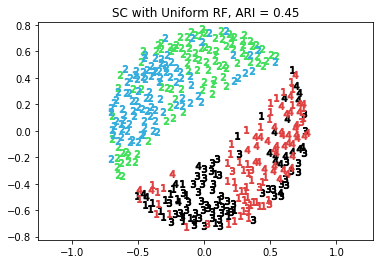

In [ ]:
#out

#plt.figure(figsize=(5,5))
for i in range(len(spectral_clusters_1)):
    if spectral_clusters_1[i] == 0:
        plt.scatter(out[i,0], out[i,1],s=200, c = colors[i], marker=TextPath((0, 0), '1', size=1000), alpha=1)
    if spectral_clusters_1[i] == 1:
        plt.scatter(out[i,0], out[i,1],s=200, c = colors[i], marker=TextPath((0, 0), '2', size=1000), alpha=1)
    if spectral_clusters_1[i] == 2:
        plt.scatter(out[i,0], out[i,1],s=200, c = colors[i], marker=TextPath((0, 0), '3', size=1000), alpha=1)
    if spectral_clusters_1[i] == 3:
        plt.scatter(out[i,0], out[i,1],s=200, c = colors[i], marker=TextPath((0, 0), '4', size=1000), alpha=1)
plt.axis('equal');
plt.title('SC with Uniform RF, ARI = 0.45')

### PAM Clustering 

In [ ]:
PAM_clusters = kMedoids(diss1,k=4)

In [ ]:
# transforming the output for the quality assessment and visualization

cluster_1 = list()
cluster_2 = list()
cluster_3 = list()
cluster_4 = list()

for i in range(len(PAM_clusters[1][0])):
    cluster_1.append(1)
    
for i in range(len(PAM_clusters[1][1])):
    cluster_2.append(2)

for i in range(len(PAM_clusters[1][2])):
    cluster_3.append(3)
    
for i in range(len(PAM_clusters[1][3])):
    cluster_4.append(4)
    
    

clust_1_df = pd.DataFrame(cluster_1,index=PAM_clusters[1][0])
clust_2_df = pd.DataFrame(cluster_2,index=PAM_clusters[1][1])
clust_3_df = pd.DataFrame(cluster_3,index=PAM_clusters[1][2])
clust_4_df = pd.DataFrame(cluster_4,index=PAM_clusters[1][3])

PAM_clusters = pd.concat([clust_1_df,clust_2_df,clust_3_df,clust_4_df
                            ])
PAM_clusters.columns = ['cluster']
PAM_clusters.sort_index(inplace=True)


In [ ]:
adjusted_rand_score(Ex2_clust,PAM_clusters['cluster'])

0.4377987619011312

In [ ]:
PAM_clusters_a = np.asarray(list(PAM_clusters['cluster']))

Text(0.5, 1.0, 'PAM with Uniform RF, ARI = 0.43')

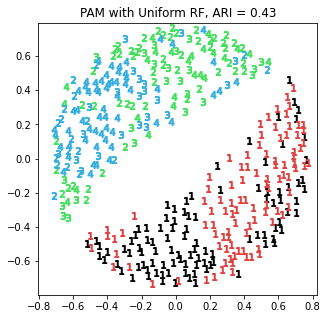

In [ ]:
#out

plt.figure(figsize=(5,5))
for i in range(len(PAM_clusters_a)):
    if PAM_clusters_a[i] == 1:
        plt.scatter(out[i,0], out[i,1],s=200, c = colors[i], marker=TextPath((0, 0), '1', size=1000), alpha=1)
    if PAM_clusters_a[i] == 2:
        plt.scatter(out[i,0], out[i,1],s=200, c = colors[i], marker=TextPath((0, 0), '2', size=1000), alpha=1)
    if PAM_clusters_a[i] == 3:
        plt.scatter(out[i,0], out[i,1],s=200, c = colors[i], marker=TextPath((0, 0), '3', size=1000), alpha=1)
    if PAM_clusters_a[i] == 4:
        plt.scatter(out[i,0], out[i,1],s=200, c = colors[i], marker=TextPath((0, 0), '4', size=1000), alpha=1)
plt.axis('equal');
plt.title('PAM with Uniform RF, ARI = 0.43')

## MDS example <a name="MDS"></a> 


In [ ]:
#DGP 
 
columns = ['X1','X2','X3','X4','X5']





cluster_1 = pd.DataFrame(np.concatenate((np.random.normal(-2,1,(150,1)), np.random.normal(-2,1,(150,1)),
                                         np.random.normal(-2,1,(150,1)),
                                         np.random.normal(-2,1,(150,1)), np.random.normal(-2,1,(150,1)), 
                                         ),axis=1),
                                         columns=columns) 
cluster_1['cluster'] = 1


cluster_2 = pd.DataFrame(np.concatenate((np.random.normal(2,1,(150,1)), np.random.normal(2,1,(150,1)),
                                         np.random.normal(2,1,(150,1)),
                                         np.random.normal(2,1,(150,1)), np.random.normal(2,1,(150,1)),
                                         ),axis=1),
                                         columns=columns)  

cluster_2['cluster'] = 2


ExM = pd.concat([cluster_1,cluster_2],ignore_index=True) # 300 rows, 10 features, cluster col.

ExM_clust = ExM['cluster']

#ExM.drop('cluster',axis=1,inplace=True)

In [ ]:
colM = colorize(ExM)

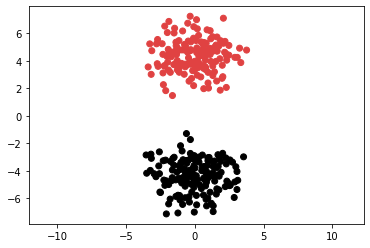

In [ ]:
out_3 = model1.fit_transform(ExM)
plt.scatter(out_3[:, 0], out_3[:, 1], c = colM,alpha=1)
plt.axis('equal');